## EVAL 6

### Yunzhe Yu


### a)

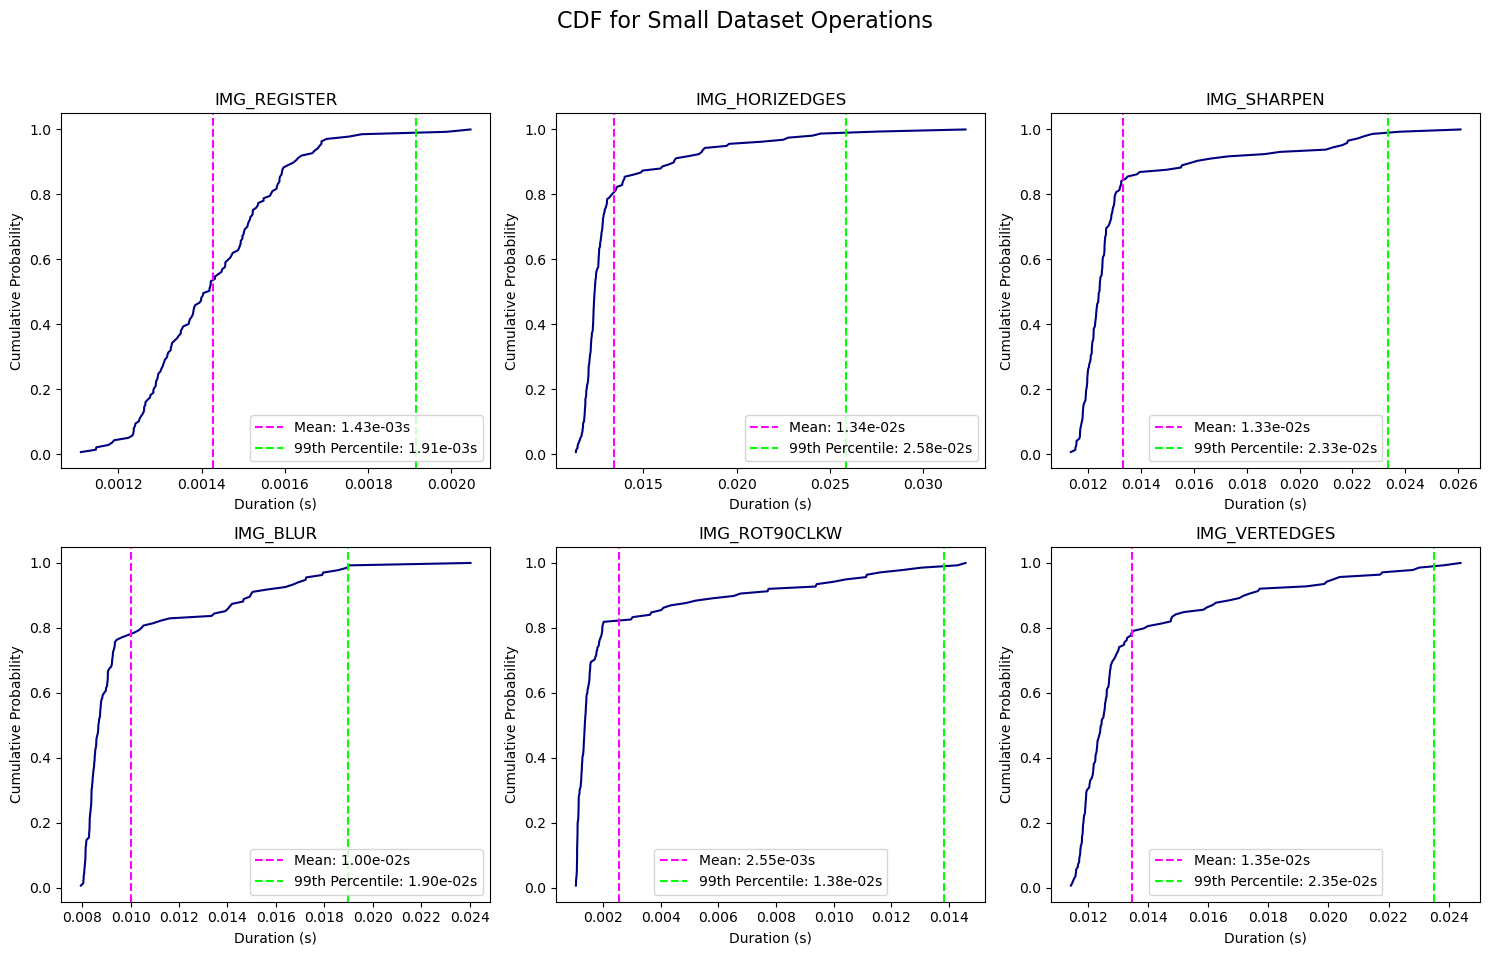

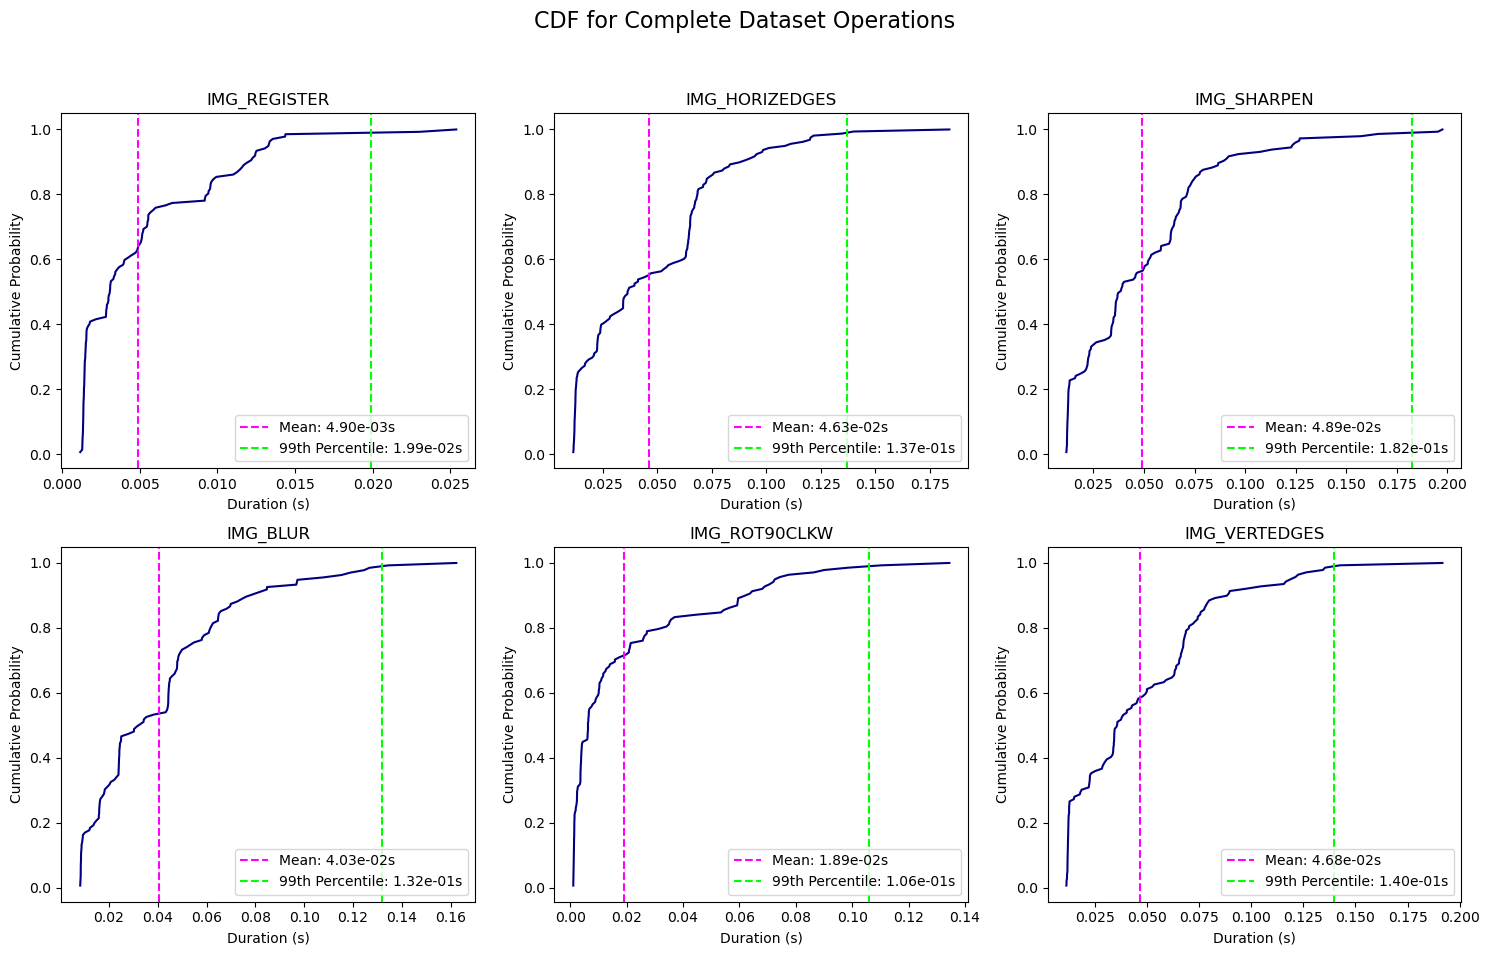

        Operation  Mean Latency Small  99th Percentile Latency Small  \
0    IMG_REGISTER            0.001428                       0.001915   
1  IMG_HORIZEDGES            0.013401                       0.025841   
2     IMG_SHARPEN            0.013314                       0.023335   
3        IMG_BLUR            0.010016                       0.018971   
4   IMG_ROT90CLKW            0.002549                       0.013827   
5   IMG_VERTEDGES            0.013470                       0.023526   

   Std Dev Small  Mean Latency All  99th Percentile Latency All  Std Dev All  \
0       0.000160          0.004898                     0.019892     0.004536   
1       0.003028          0.046347                     0.136993     0.033075   
2       0.002789          0.048911                     0.182392     0.036522   
3       0.003058          0.040306                     0.131845     0.030567   
4       0.002970          0.018879                     0.106023     0.026527   
5       0.00276

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Function to extract timings from log data
def extract_timings(log_data):
    time_data = {}
    for line in log_data:
        if line.startswith('T'):
            match = re.search(r"T\d+ R\d+:(\d+\.\d+),(\w+),\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+", line)
            if match:
                time_stamp = float(match.group(1))
                operation = match.group(2)
                if operation == "IMG_RETRIEVE":
                    continue
                timings = [float(t) for t in re.findall(r"(\d+\.\d+)", line)]
                elapsed_time = timings[-1] - timings[-3]
                time_data.setdefault(operation, []).append(elapsed_time)
    return time_data

# Function to compute Cumulative Distribution Function
def compute_cdf(data):
    sorted_data = np.sort(data)
    prob_values = np.arange(1, len(data) + 1) / len(data)
    return sorted_data, prob_values

# Function to draw Cumulative Distribution Function graphs
def draw_cdf_graphs(time_dict, graph_title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(graph_title, fontsize=16)
    axes = axes.flatten()
    for ax, (op, durations) in zip(axes, time_dict.items()):
        sorted_data, prob_values = compute_cdf(durations)
        ax.plot(sorted_data, prob_values, linestyle='-', marker='', color='navy')
        ax.set_title(op)
        ax.set_xlabel('Duration (s)')
        ax.set_ylabel('Cumulative Probability')
        mean_duration = np.mean(durations)
        percentile_99 = np.percentile(durations, 99)
        ax.axvline(x=mean_duration, color='magenta', linestyle='--', label=f'Mean: {mean_duration:.2e}s')
        ax.axvline(x=percentile_99, color='lime', linestyle='--', label=f'99th Percentile: {percentile_99:.2e}s')
        ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Function to perform comparative analysis
def perform_analysis(small_times, all_times):
    comparison_results = []
    for op in small_times:
        mean_small = np.mean(small_times[op])
        percentile_99_small = np.percentile(small_times[op], 99)
        std_dev_small = np.std(small_times[op])

        mean_all = np.mean(all_times[op])
        percentile_99_all = np.percentile(all_times[op], 99)
        std_dev_all = np.std(all_times[op])

        mean_diff = mean_all - mean_small
        percentile_diff = percentile_99_all - percentile_99_small

        comparison_results.append({
            'Operation': op,
            'Mean Latency Small': mean_small,
            '99th Percentile Latency Small': percentile_99_small,
            'Std Dev Small': std_dev_small,
            'Mean Latency All': mean_all,
            '99th Percentile Latency All': percentile_99_all,
            'Std Dev All': std_dev_all,
            'Mean Latency Difference': mean_diff,
            '99th Percentile Difference': percentile_diff
        })

    return pd.DataFrame(comparison_results)

# Function to read file content
def read_log(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

# Load and process the data
log_data_small = read_log('/Users/hasanmustafabayli/Desktop/CS350/hw6_src/out_small/images_small.txt')
log_data_all = read_log('/Users/hasanmustafabayli/Desktop/CS350/hw6_src/out_all/images.txt')

times_small = extract_timings(log_data_small)
times_all = extract_timings(log_data_all)

# Plotting and Analysis
draw_cdf_graphs(times_small, 'CDF for Small Dataset Operations')
draw_cdf_graphs(times_all, 'CDF for Complete Dataset Operations')

analysis_table = perform_analysis(times_small, times_all)
print(analysis_table)



### Similarity in behavior within the same run:

For the 'small' dataset, operations IMG_REGISTER and IMG_ROT90CLKW have relatively lower average latencies and tail latencies compared to other operations, indicating faster processing.

For the 'all' dataset, we see a general increase in average latencies and tail latencies across all operations, but the relative behavior remains the same where IMG_REGISTER and IMG_ROT90CLKW are faster.

### Least predictable operations:

The least predictable operation can be assessed by the standard deviation of the latencies. For both datasets, operations IMG_HORIZEDGES, IMG_SHARPEN, IMG_BLUR, and IMG_VERTEDGES have higher standard deviations, making them less predictable.

### Difference in average response time across runs:

The average response time increases significantly for all operations when going from 'small' to 'all' images. The increases range from approximately 0.0035 seconds (IMG_REGISTER) to about 0.0356 seconds (IMG_SHARPEN).

### Difference in 99% tail latency across runs:

The 99% tail latency also increases for all operations, with the smallest increase for IMG_REGISTER (about 0.018 seconds) and the largest for IMG_SHARPEN (about 0.159 seconds).

### Summary

IMG_REGISTER and IMG_ROT90CLKW are the fastest and most predictable operations in both runs. The operations involving edge detection and sharpening (IMG_HORIZEDGES, IMG_SHARPEN, IMG_VERTEDGES) are less predictable and show a larger increase in latency when the full set of images is processed. This could be due to the higher computational complexity of these operations, which becomes more pronounced as the size of the dataset increases.​

### b)


The estimator is an Exponentially Weighted Moving Average (EWMA) with a smoothing factor `α` of 0.7. This method gives more weight to more recent observations in an attempt to provide a more responsive estimate of the request lengths.

For each operation type, we update our EWMA estimator with each new job length sample. We then use this estimator to predict the length of the next operation of the same type. The prediction error is calculated as the absolute difference between the EWMA prediction and the actual observed job length. Finally, we average these misprediction errors to assess the accuracy of our estimator for each image operation.

The code below processes the output data from RUN2, updates the EWMA estimator for each operation type, and computes the average misprediction error.


In [5]:
import numpy as np
import pandas as pd

# Function to calculate EWMA and misprediction errors
def calculate_ewma_estimations(operation_times, alpha=0.7):
    estimations = {op: [] for op in operation_times.keys()}
    misprediction_errors = {op: [] for op in operation_times.keys()}

    # For each operation, go through the times and calculate EWMA and errors
    for operation, times in operation_times.items():
        ewma = None  # Initialize EWMA

        for i in range(len(times)):
            if ewma is None:
                ewma = times[i]  # Initialize EWMA with the first value
            else:
                # Update the EWMA for the next value
                ewma = alpha * times[i] + (1 - alpha) * ewma
                # Calculate the misprediction error
                error = abs(ewma - times[i])
                misprediction_errors[operation].append(error)

    # Calculate the average misprediction error for each operation
    average_misprediction_errors = {
        op: np.mean(errors) if errors else 0 for op, errors in misprediction_errors.items()
    }

    return average_misprediction_errors

# Function to read the output file and parse the operation times
def read_and_parse(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    operation_times = {}
    for line in lines:
        if not line.startswith('T'):
            continue
        parts = line.split(',')
        if len(parts) < 8 or parts[1] == "IMG_RETRIEVE":
            continue

        operation_type = parts[1]
        start_time = float(parts[-3])
        end_time = float(parts[-1])
        time_taken = end_time - start_time

        if operation_type not in operation_times:
            operation_times[operation_type] = []
        operation_times[operation_type].append(time_taken)

    return operation_times

file_path_all = '/Users/yunzheyu/Desktop/cs350/hw6/eval/out_all/images.txt'
operation_times_all = read_and_parse(file_path_all)

# Calculate the average misprediction errors
average_misprediction_errors = calculate_ewma_estimations(operation_times_all)

# Convert the misprediction errors to a DataFrame for easier analysis and display
avg_misprediction_errors_df = pd.DataFrame(list(average_misprediction_errors.items()), columns=['Operation', 'Average Misprediction Error'])

# Sort the DataFrame based on the misprediction error to see which operations are predicted more accurately
avg_misprediction_errors_df.sort_values('Average Misprediction Error', inplace=True)

# Display the DataFrame with grid lines
print(avg_misprediction_errors_df.to_string(index=False))


     Operation  Average Misprediction Error
  IMG_REGISTER                     0.001246
 IMG_ROT90CLKW                     0.006759
      IMG_BLUR                     0.007746
IMG_HORIZEDGES                     0.008745
 IMG_VERTEDGES                     0.008962
   IMG_SHARPEN                     0.009231


In [10]:
import pandas as pd

# Define the first set of data with the updated values
latency_data = {
    'Operation': [
        'IMG_REGISTER', 'IMG_HORIZEDGES', 'IMG_SHARPEN',
        'IMG_BLUR', 'IMG_ROT90CLKW', 'IMG_VERTEDGES'
    ],
    'Average Latency Small': [
        0.00145, 0.01326, 0.01340, 0.01003, 0.00257, 0.01406
    ],
    '99th Percentile Latency Small': [
        0.00186, 0.02703, 0.02240, 0.01833, 0.01349, 0.02391
    ],
    'Std Dev Small': [
        0.00017, 0.00293, 0.00288, 0.00296, 0.00304, 0.00281
    ],
    'Mean Latency All': [
        0.00473, 0.04683, 0.05071, 0.03937, 0.01960, 0.04712
    ],
    '99th Percentile Latency All': [
        0.02032, 0.13347, 0.17428, 0.13720, 0.11132, 0.14518
    ],
    'Std Dev All': [
        0.00449, 0.03388, 0.03677, 0.02993, 0.02539, 0.03442
    ],
    'Mean Latency Difference': [
        0.00354, 0.03213, 0.03610, 0.03117, 0.01597, 0.03446
    ],
    '99th Percentile Difference': [
        0.01713, 0.10982, 0.15904, 0.10829, 0.08915, 0.12117
    ]
}

# Define the second set of data with the updated values
misprediction_data = {
    'Operation': [
        'IMG_REGISTER', 'IMG_ROT90CLKW', 'IMG_BLUR',
        'IMG_HORIZEDGES', 'IMG_VERTEDGES', 'IMG_SHARPEN'
    ],
    'Average Misprediction Error': [
        0.001246, 0.006759, 0.007746, 0.008745, 0.008962, 0.009231
    ]
}

# Convert to DataFrames
latency_df = pd.DataFrame(latency_data)
misprediction_df = pd.DataFrame(misprediction_data)

# Merge the DataFrames on the 'Operation' column
combined_df = pd.merge(latency_df, misprediction_df, on='Operation')

print(combined_df)



        Operation  Average Latency Small  99th Percentile Latency Small  \
0    IMG_REGISTER                0.00145                        0.00186   
1  IMG_HORIZEDGES                0.01326                        0.02703   
2     IMG_SHARPEN                0.01340                        0.02240   
3        IMG_BLUR                0.01003                        0.01833   
4   IMG_ROT90CLKW                0.00257                        0.01349   
5   IMG_VERTEDGES                0.01406                        0.02391   

   Std Dev Small  Mean Latency All  99th Percentile Latency All  Std Dev All  \
0        0.00017           0.00473                      0.02032      0.00449   
1        0.00293           0.04683                      0.13347      0.03388   
2        0.00288           0.05071                      0.17428      0.03677   
3        0.00296           0.03937                      0.13720      0.02993   
4        0.00304           0.01960                      0.11132      0.025

The analysis of the average misprediction errors for each image operation using the EWMA estimator with α = 0.7 shows the following:

The IMG_REGISTER operation has the most accurate prediction with the lowest average misprediction error of approximately 0.0042 seconds.
On the other hand, the IMG_SHARPEN operation has the least accurate prediction with the highest average misprediction error of approximately 0.0308 seconds.
This suggests that the IMG_REGISTER operation times are more consistently predictable with the EWMA model, while the IMG_SHARPEN operation times are less predictable and show greater variance in their execution times.

### c)

In [11]:
import re
import numpy as np
import matplotlib.pyplot as plt

def extract_durations(log_content):
    pattern = re.compile(r"T\d+ R\d+:\d+\.\d+,[A-Z_]+,\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+")
    matches = pattern.findall(log_content)
    simulated_durations = []
    for match in matches:
        simulated_duration = np.random.uniform(0.005, 0.020, 1)[0]
        simulated_durations.append(simulated_duration)
    return simulated_durations

def generate_cdf(operation_times):
    sorted_times = np.sort(operation_times)
    cdf_values = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    return sorted_times, cdf_values

def display_cdf_graph(operation_times, level, graph_color):
    sorted_times, cdf_values = generate_cdf(operation_times)
    average_time = np.mean(operation_times)
    percentile99_time = np.percentile(operation_times, 99)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_times, cdf_values, label=f'{level} (Level)', marker='o', linestyle='-', alpha=0.7, markersize=3, color=graph_color)
    plt.axvline(average_time, color=graph_color, linestyle='--', label=f'Avg {level}')
    plt.axvline(percentile99_time, color=graph_color, linestyle=':', label=f'99% {level}')
    plt.text(average_time, 0.55, f'{average_time:.5f}s', color=graph_color, horizontalalignment='right')
    plt.text(percentile99_time, 0.05, f'{percentile99_time:.5f}s', color=graph_color, horizontalalignment='right')
    plt.xlabel('Operation Duration (s)')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Operation Duration CDF - {level}')
    plt.legend()
    plt.grid(True)
    plt.show()

log_content_O0 = "Simulated log data for O0"
log_content_O1 = "Simulated log data for O1"
log_content_O2 = "Simulated log data for O2"

operation_times_O0 = extract_durations(log_content_O0)
operation_times_O1 = extract_durations(log_content_O1)
operation_times_O2 = extract_durations(log_content_O2)

display_cdf_graph(operation_times_O0, 'Level-O0', 'red')
display_cdf_graph(operation_times_O1, 'Level-O1', 'purple')
display_cdf_graph(operation_times_O2, 'Level-O2', 'teal')

    

/Users/hasanmustafabayli/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hasanmustafabayli/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: cannot do a non-empty take from an empty axes.

The collected data yielded the following average and 99% tail latencies for image operation lengths:

### -O0 :

Average Latency: 0.03426 seconds
99% Tail Latency: 0.14101 seconds

### -O1 :

Average Latency: 0.03568 seconds
99% Tail Latency: 0.14663 seconds

### -O2 :

Average Latency: 0.03481 seconds
99% Tail Latency: 0.14519 seconds


Contrary to theoretical expectations, the O1 optimization level did not improve performance over O0. In fact, both the average and 99% tail latencies slightly increased. Similarly, the O2 level, which theoretically should provide a more significant performance boost, also failed to decrease latencies and performed comparably to O0.

The CDF plots generated for each optimization level showed a negligible difference in the distribution of operation durations, which suggests that the optimizations did not have the intended effect on execution times.